In [1]:
# Example of alternative execution backend for pythonflow

# Installation:
# conda install graphviz
# conda create --name myenv
# source activate myenv
# conda install pythonflow, pip
# pip install graphviz

In [2]:
import pythonflow as pf
import functools
import contextlib
import time
import graphviz

In [3]:
class Backend(object):
    def __init__(self):
        pass
    
    def evaluate(self, operation, context, _evaluate, *args, **kwargs):
        raise NotImplementedError()
      
    @contextlib.contextmanager
    def __call__(self, operation, context):
        _evaluate = operation._evaluate
        operation._evaluate = functools.partial(self.evaluate, operation, context, _evaluate)
        yield
        operation._evaluate = _evaluate

class Node(object):
    def __init__(self, name, value, *args, **kwargs):
        self.name = name
        self.value = value
        self.args = args
        self.kwargs = kwargs
        
    def __repr__(self):
        return '%s(%s, %s)' % (self.name, self.args, self.kwargs)
        
class GraphvizBackend(Backend):
    def __init__(self):
        super(GraphvizBackend, self).__init__()
        self.graph = graphviz.Digraph()
    
    def evaluate(self, operation, context, _evaluate, *args, **kwargs):
        args_values = [a.value if isinstance(a, Node) else a for a in args]
        kwarg_values = {k: kwargs[k].value if isinstance(kwargs[k], Node) else kwargs[k] for k in kwargs}
        
        value = _evaluate(*args_values, **kwarg_values)
        node = Node(operation.name, value, *args, **kwargs)
        
        self.graph.node(node.name, node.name + ' = %s' % node.value)
        for arg in args:
            if isinstance(arg, Node):
                self.graph.node(arg.name, arg.name + ' = %s' % arg.value)
                self.graph.edge(arg.name, node.name)
            else:
                self.graph.node(str(arg))
                self.graph.edge(str(arg), node.name)
        
        return node

In [4]:
def func(a, b):
    return a + b

# Graph definition
with pf.Graph() as graph:
    x = pf.placeholder('x')
    a = pf.constant(1, name='a')
    b = pf.constant(2, name='b')
    z = pf.func_op(func, a, b).set_name('z')
    r = pf.func_op(func, z, x).set_name('r')
    g = pf.func_op(func, a, z).set_name('g')

In [5]:
# Evaluate graph without backend
graph([r, g], {x: 3})

(6, 4)

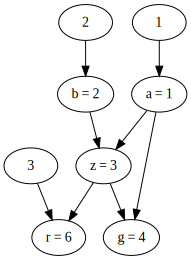

In [6]:
# Evaluate graph using a graphviz backend
backend = GraphvizBackend()
graph([r, g], {x: 3}, callback=backend)
backend.graph